## 1. Setup & Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Project imports
from data.loader import load_raw_data
from models.forecasting import (
    # Data prep
    create_date_column,
    aggregate_by_period,
    prepare_time_series,
    
    # Analysis
    check_stationarity,
    decompose_time_series,
    
    # Models
    train_arima,
    train_sarima,
    train_exponential_smoothing,
    
    # Baselines
    moving_average_forecast,
    naive_forecast,
    
    # Forecasting & Evaluation
    forecast,
    evaluate_forecast,
    train_test_split_ts,
    
    # Visualization
    plot_time_series,
    plot_decomposition,
    plot_forecast,
    plot_model_comparison,
    
    # Flags
    STATSMODELS_AVAILABLE,
    PROPHET_AVAILABLE
)

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Output paths
FIGURES_PATH = project_root / 'outputs' / 'figures'
TABLES_PATH = project_root / 'outputs' / 'tables'

print("✅ Imports successful!")
print(f"📦 statsmodels available: {STATSMODELS_AVAILABLE}")
print(f"📦 prophet available: {PROPHET_AVAILABLE}")

✅ Imports successful!
📦 statsmodels available: True
📦 prophet available: False


## 2. Load Raw Data

In [4]:
# Load raw data
data_path = project_root / 'data' / 'raw' / 'hotel_bookings.csv'
df = load_raw_data(file_path=str(data_path))
print(f"\n📊 Dataset shape: {df.shape}")
print(f"\n📅 Date columns:")
print(f"   - arrival_date_year: {df['arrival_date_year'].unique()}")
print(f"   - arrival_date_month: {df['arrival_date_month'].nunique()} unique months")

Loading data from: c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\data\raw\hotel_bookings.csv
✓ Loaded 119,390 rows, 32 columns

📊 Dataset shape: (119390, 32)

📅 Date columns:
   - arrival_date_year: [2015 2016 2017]
   - arrival_date_month: 12 unique months


## 3. Prepare Time Series Data

In [5]:
# Prepare monthly time series
ts_df = prepare_time_series(
    df,
    year_col='arrival_date_year',
    month_col='arrival_date_month',
    day_col='arrival_date_day_of_month',
    target_col='is_canceled',
    period='M',
    verbose=True
)

print("\n📊 Time Series DataFrame:")
ts_df

PREPARING TIME SERIES DATA
✅ Created 'arrival_date' column
   Date range: 2015-07-01 00:00:00 to 2017-08-31 00:00:00

📊 Monthly Aggregation:
   Periods: 26
   Date range: 2015-07-31 00:00:00 to 2017-08-31 00:00:00
   Avg cancellation rate: 36.28%
   Min cancellation rate: 20.77%
   Max cancellation rate: 45.35%

📊 Time Series DataFrame:


,period,total_bookings,cancellations,cancellation_rate
0,2015-07-31,2776,1259,0.453530
1,2015-08-31,3889,1598,0.410903
2,2015-09-30,5114,2094,0.409464
3,2015-10-31,4957,1732,0.349405
4,2015-11-30,2340,486,0.207692
5,2015-12-31,2920,973,0.333219
6,2016-01-31,2248,557,0.247776
7,2016-02-29,3891,1337,0.343613
8,2016-03-31,4824,1477,0.306177
9,2016-04-30,5428,2061,0.379698


In [6]:
# Display summary statistics
print("\n📊 Time Series Statistics:")
print(ts_df[['total_bookings', 'cancellations', 'cancellation_rate']].describe())


📊 Time Series Statistics:
       total_bookings  cancellations  cancellation_rate
count       26.000000      26.000000          26.000000
mean      4591.923077    1700.923077           0.362811
std       1115.120367     557.572375           0.055776
min       2248.000000     486.000000           0.207692
25%       3889.500000    1368.750000           0.337209
50%       4941.000000    1702.000000           0.364743
75%       5373.750000    2051.250000           0.402983
max       6313.000000    2762.000000           0.453530


## 4. Visualize Time Series

✅ Saved time series plot to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\ts_cancellation_rate.png


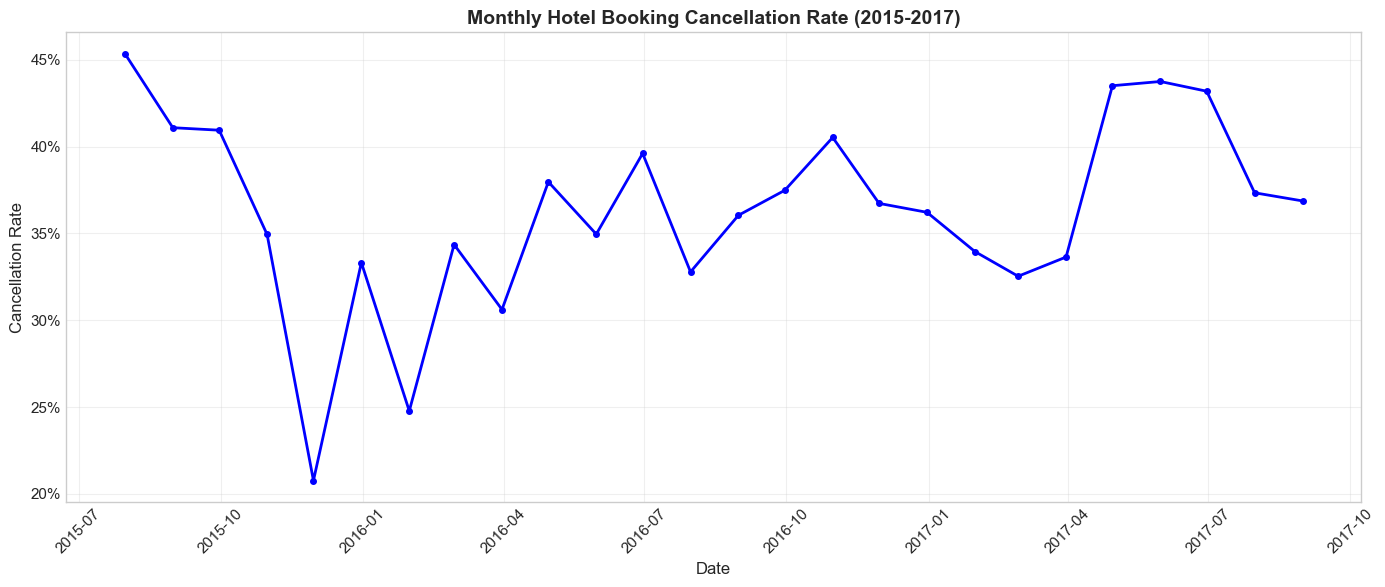

In [7]:
# Plot cancellation rate over time
fig = plot_time_series(
    ts_df,
    date_col='period',
    value_col='cancellation_rate',
    title='Monthly Hotel Booking Cancellation Rate (2015-2017)',
    figsize=(14, 6),
    save_path=str(FIGURES_PATH / 'ts_cancellation_rate.png'),
    show=True
)

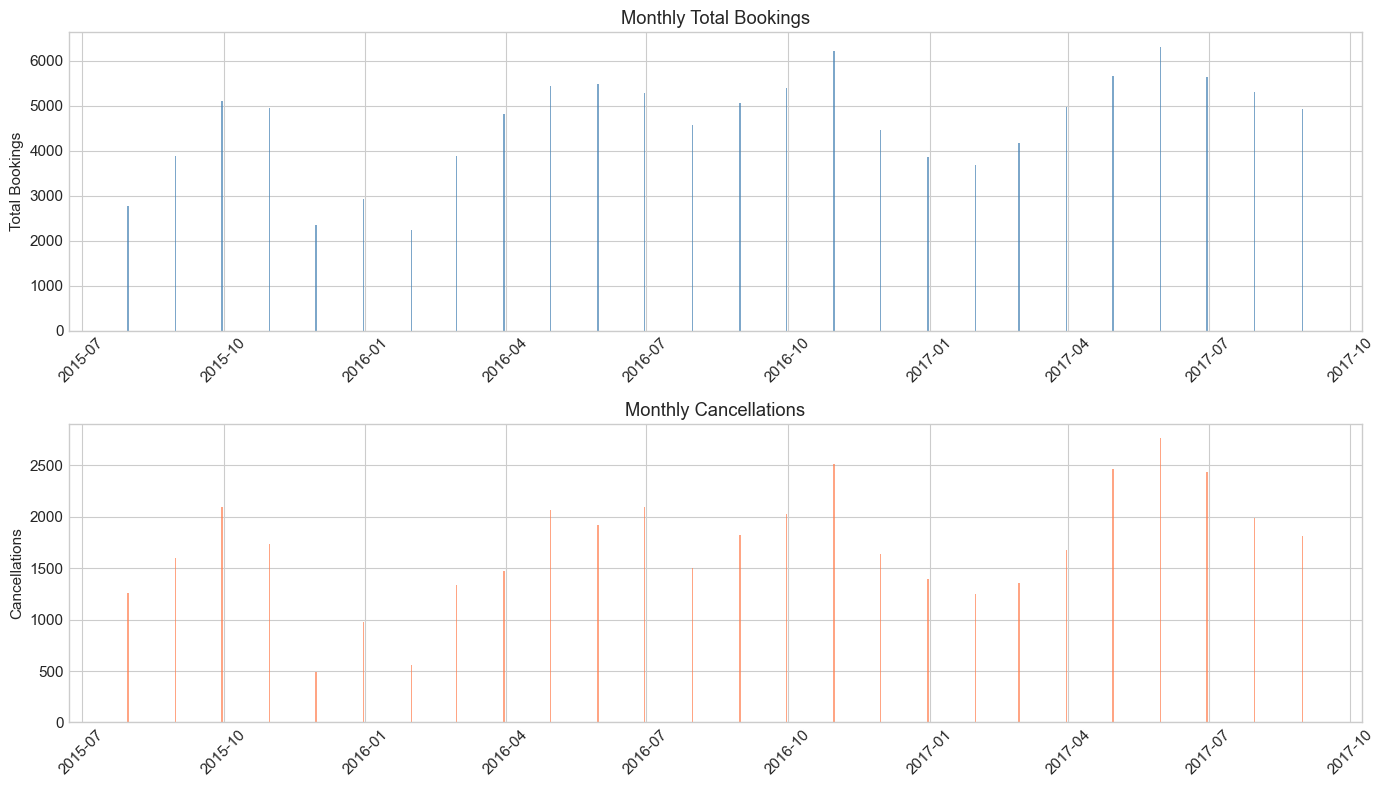

✅ Saved to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\ts_bookings_cancellations.png


In [8]:
# Plot total bookings and cancellations
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Total bookings
axes[0].bar(ts_df['period'], ts_df['total_bookings'], color='steelblue', alpha=0.7)
axes[0].set_ylabel('Total Bookings')
axes[0].set_title('Monthly Total Bookings')
axes[0].tick_params(axis='x', rotation=45)

# Cancellations
axes[1].bar(ts_df['period'], ts_df['cancellations'], color='coral', alpha=0.7)
axes[1].set_ylabel('Cancellations')
axes[1].set_title('Monthly Cancellations')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ts_bookings_cancellations.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved to {FIGURES_PATH / 'ts_bookings_cancellations.png'}")

## 5. Time Series Analysis

In [9]:
# Create series with datetime index
series = ts_df.set_index('period')['cancellation_rate']
print(f"📊 Time series length: {len(series)}")
print(f"📅 Date range: {series.index.min()} to {series.index.max()}")

📊 Time series length: 26
📅 Date range: 2015-07-31 00:00:00 to 2017-08-31 00:00:00


In [10]:
# Check stationarity
if STATSMODELS_AVAILABLE:
    stationarity_result = check_stationarity(series, significance_level=0.05, verbose=True)
else:
    print("⚠️ statsmodels not available, skipping stationarity test")


📊 Augmented Dickey-Fuller Test:
   ADF Statistic: -1.4377
   P-Value: 0.5641
   Used Lags: 5
   Critical Values:
      1%: -3.8092
      5%: -3.0216
      10%: -2.6507

   Conclusion: Series is NON-STATIONARY



📊 Time Series Decomposition (additive):
   Period: 12
   Trend range: 0.3328 to 0.3795
   Seasonal range: -0.0669 to 0.0459
✅ Saved decomposition plot to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\ts_decomposition.png


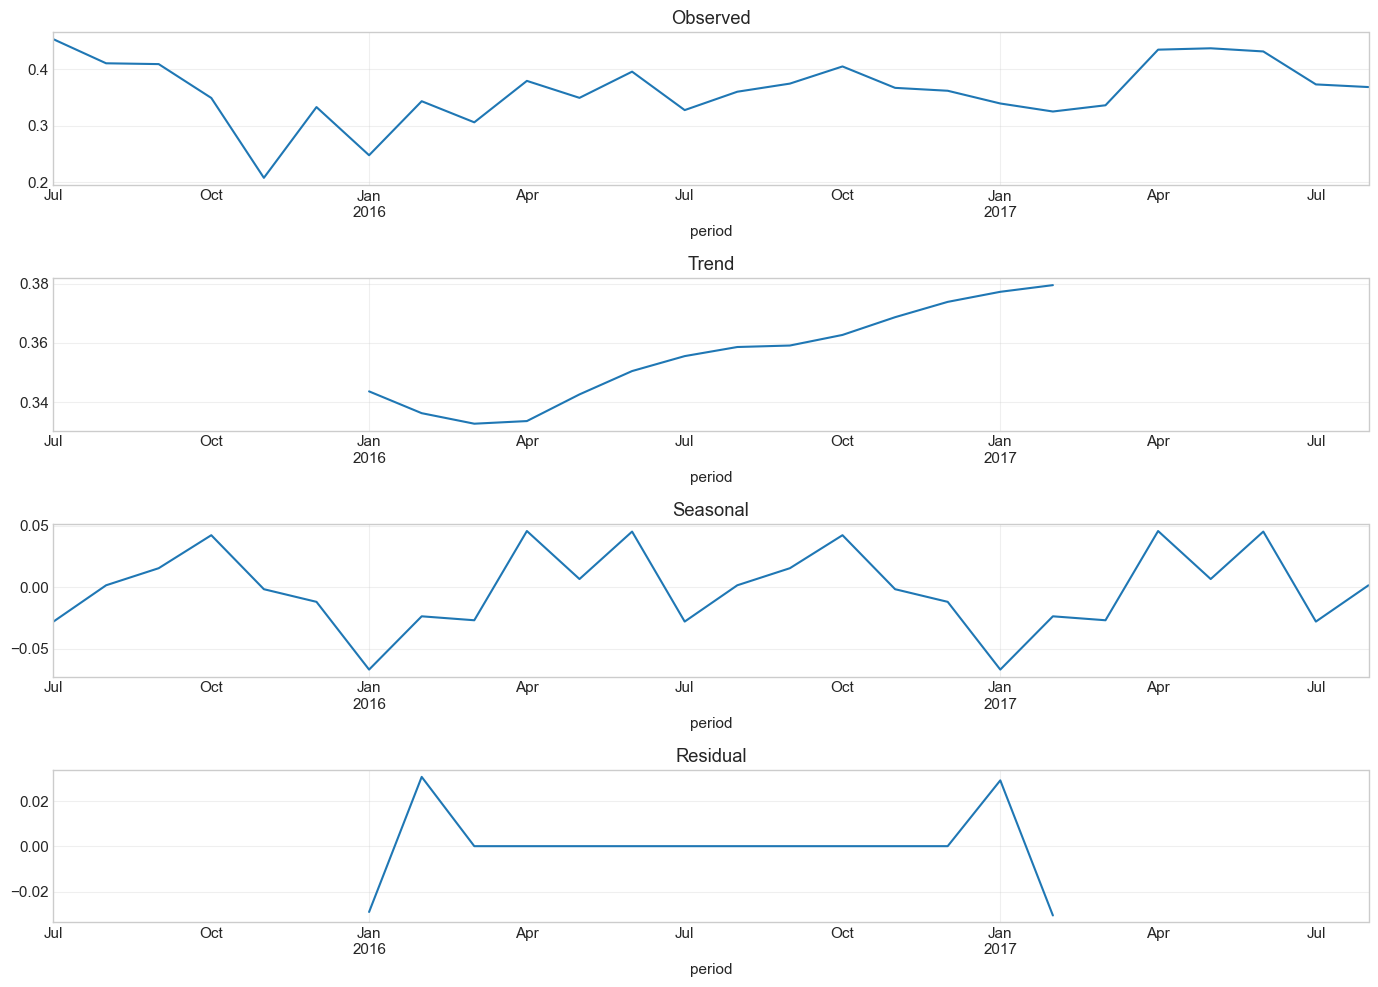

In [11]:
# Time series decomposition
if STATSMODELS_AVAILABLE and len(series) >= 24:  # Need at least 2 years for yearly seasonality
    decomposition = decompose_time_series(series, period=12, model='additive', verbose=True)
    
    if decomposition is not None:
        fig = plot_decomposition(
            decomposition,
            figsize=(14, 10),
            save_path=str(FIGURES_PATH / 'ts_decomposition.png'),
            show=True
        )
else:
    print(f"⚠️ Not enough data for seasonal decomposition (have {len(series)} periods, need ≥24)")

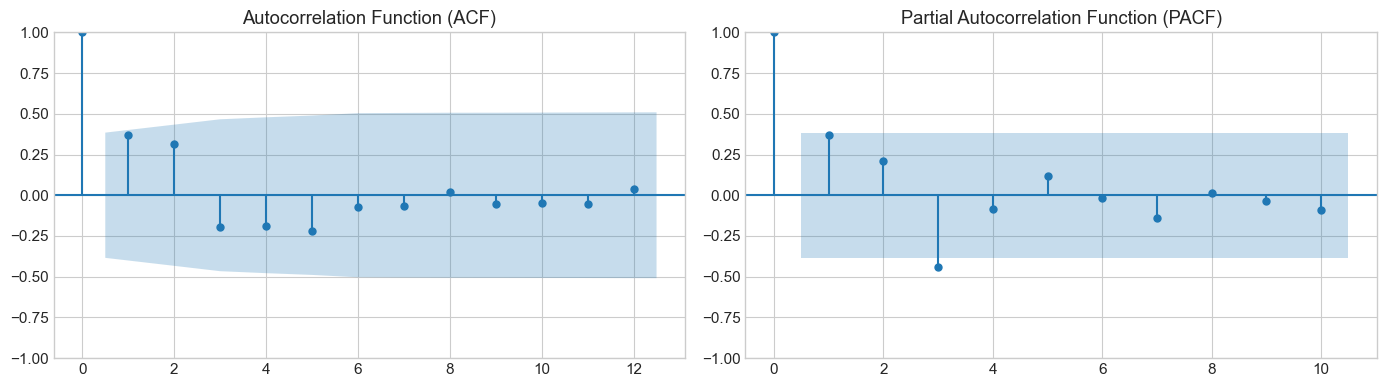

✅ Saved to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\ts_acf_pacf.png


In [12]:
# Plot ACF and PACF
if STATSMODELS_AVAILABLE:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    plot_acf(series.dropna(), lags=min(20, len(series)//2 - 1), ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    plot_pacf(series.dropna(), lags=min(10, len(series)//2 - 2), ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / 'ts_acf_pacf.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved to {FIGURES_PATH / 'ts_acf_pacf.png'}")

## 6. Train-Test Split

In [13]:
# Use last 6 months as test set
TEST_PERIODS = 6

train, test = train_test_split_ts(series, test_size=TEST_PERIODS, verbose=True)

print(f"\n📊 Training set:")
print(f"   Period: {train.index.min()} to {train.index.max()}")
print(f"   Mean: {train.mean():.4f}")

print(f"\n📊 Test set:")
print(f"   Period: {test.index.min()} to {test.index.max()}")
print(f"   Mean: {test.mean():.4f}")


📊 Train-Test Split:
   Train size: 20
   Test size: 6

📊 Training set:
   Period: 2015-07-31 00:00:00 to 2017-02-28 00:00:00
   Mean: 0.3525

📊 Test set:
   Period: 2017-03-31 00:00:00 to 2017-08-31 00:00:00
   Mean: 0.3972


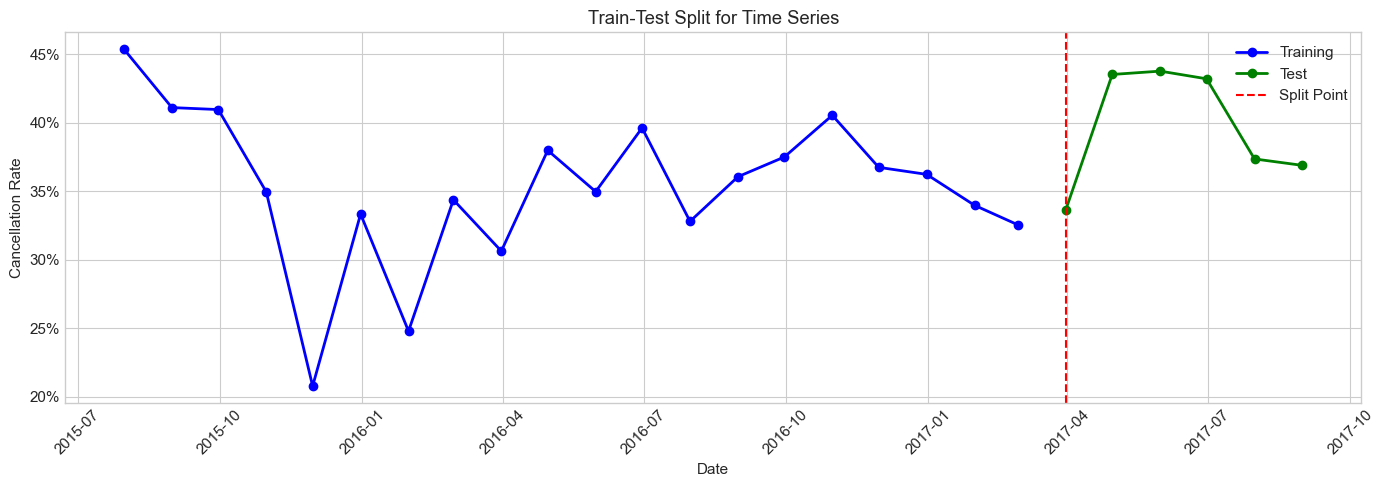

✅ Saved to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\figures\ts_train_test_split.png


In [14]:
# Visualize train-test split
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train.index, train.values, 'b-o', label='Training', linewidth=2, markersize=6)
ax.plot(test.index, test.values, 'g-o', label='Test', linewidth=2, markersize=6)
ax.axvline(x=test.index[0], color='red', linestyle='--', label='Split Point')

ax.set_xlabel('Date')
ax.set_ylabel('Cancellation Rate')
ax.set_title('Train-Test Split for Time Series')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ts_train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved to {FIGURES_PATH / 'ts_train_test_split.png'}")

## 7. Baseline Models

In [15]:
# Store all results
all_results = {}

In [16]:
# Naive forecast (last value)
naive_pred = naive_forecast(train, forecast_periods=TEST_PERIODS, verbose=True)
naive_metrics = evaluate_forecast(test.values, naive_pred.values, 'Naive', verbose=True)
all_results['Naive'] = {'forecast': naive_pred, 'metrics': naive_metrics}


📊 Naive Forecast:
   Periods: 6

📊 Naive Forecast Evaluation:
   MAE:  0.0718
   RMSE: 0.0819
   MAPE: 17.24%


In [17]:
# Moving Average (window=3)
ma3_pred = moving_average_forecast(train, window=3, forecast_periods=TEST_PERIODS, verbose=True)
ma3_metrics = evaluate_forecast(test.values, ma3_pred.values, 'MA(3)', verbose=True)
all_results['MA(3)'] = {'forecast': ma3_pred, 'metrics': ma3_metrics}


📊 Moving Average Forecast (window=3):
   Forecast value: 0.3424
   Periods: 6

📊 MA(3) Forecast Evaluation:
   MAE:  0.0568
   RMSE: 0.0675
   MAPE: 13.50%


In [18]:
# Moving Average (window=6)
ma6_pred = moving_average_forecast(train, window=6, forecast_periods=TEST_PERIODS, verbose=True)
ma6_metrics = evaluate_forecast(test.values, ma6_pred.values, 'MA(6)', verbose=True)
all_results['MA(6)'] = {'forecast': ma6_pred, 'metrics': ma6_metrics}


📊 Moving Average Forecast (window=6):
   Forecast value: 0.3624
   Periods: 6

📊 MA(6) Forecast Evaluation:
   MAE:  0.0434
   RMSE: 0.0526
   MAPE: 10.39%


## 8. ARIMA Models

In [19]:
if STATSMODELS_AVAILABLE:
    # ARIMA(1,1,1)
    try:
        arima_model, arima_info = train_arima(train, order=(1, 1, 1), verbose=True)
        arima_forecast_df = forecast(arima_model, steps=TEST_PERIODS, model_type='arima', verbose=True)
        arima_metrics = evaluate_forecast(test.values, arima_forecast_df['forecast'].values, 'ARIMA(1,1,1)', verbose=True)
        all_results['ARIMA(1,1,1)'] = {
            'model': arima_model,
            'forecast': arima_forecast_df,
            'metrics': arima_metrics
        }
    except Exception as e:
        print(f"⚠️ ARIMA(1,1,1) failed: {e}")
else:
    print("⚠️ statsmodels not available, skipping ARIMA")


TRAINING ARIMA(1, 1, 1)
   AIC: -52.86
   BIC: -50.03
   Observations: 20

📈 Generating 6-step forecast...
   Forecast mean: 0.3267
   Forecast range: 0.3259 to 0.3276

📊 ARIMA(1,1,1) Forecast Evaluation:
   MAE:  0.0705
   RMSE: 0.0809
   MAPE: 16.89%


In [20]:
if STATSMODELS_AVAILABLE:
    # ARIMA(2,1,2)
    try:
        arima2_model, arima2_info = train_arima(train, order=(2, 1, 2), verbose=True)
        arima2_forecast_df = forecast(arima2_model, steps=TEST_PERIODS, model_type='arima', verbose=True)
        arima2_metrics = evaluate_forecast(test.values, arima2_forecast_df['forecast'].values, 'ARIMA(2,1,2)', verbose=True)
        all_results['ARIMA(2,1,2)'] = {
            'model': arima2_model,
            'forecast': arima2_forecast_df,
            'metrics': arima2_metrics
        }
    except Exception as e:
        print(f"⚠️ ARIMA(2,1,2) failed: {e}")


TRAINING ARIMA(2, 1, 2)
   AIC: -49.16
   BIC: -44.44
   Observations: 20

📈 Generating 6-step forecast...
   Forecast mean: 0.3249
   Forecast range: 0.3224 to 0.3277

📊 ARIMA(2,1,2) Forecast Evaluation:
   MAE:  0.0723
   RMSE: 0.0828
   MAPE: 17.33%


## 9. SARIMA Models

In [21]:
if STATSMODELS_AVAILABLE and len(train) >= 24:
    # SARIMA with yearly seasonality (s=12)
    try:
        sarima_model, sarima_info = train_sarima(
            train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            verbose=True
        )
        sarima_forecast_df = forecast(sarima_model, steps=TEST_PERIODS, model_type='sarima', verbose=True)
        sarima_metrics = evaluate_forecast(test.values, sarima_forecast_df['forecast'].values, 'SARIMA', verbose=True)
        all_results['SARIMA(1,1,1)(1,1,1,12)'] = {
            'model': sarima_model,
            'forecast': sarima_forecast_df,
            'metrics': sarima_metrics
        }
    except Exception as e:
        print(f"⚠️ SARIMA failed: {e}")
else:
    print(f"⚠️ Not enough data for SARIMA (have {len(train)} periods, need ≥24)")

⚠️ Not enough data for SARIMA (have 20 periods, need ≥24)


## 10. Exponential Smoothing

In [23]:
# Reload module after fix
import importlib
import models.forecasting as forecasting_module
importlib.reload(forecasting_module)
from models.forecasting import forecast, train_exponential_smoothing

if STATSMODELS_AVAILABLE and len(train) >= 24:
    # Holt-Winters with additive trend and seasonality
    try:
        hw_model, hw_info = train_exponential_smoothing(
            train,
            trend='add',
            seasonal='add',
            seasonal_periods=12,
            verbose=True
        )
        hw_forecast_df = forecast(hw_model, steps=TEST_PERIODS, model_type='exp_smoothing', verbose=True)
        hw_metrics = evaluate_forecast(test.values, hw_forecast_df['forecast'].values, 'Holt-Winters', verbose=True)
        all_results['Holt-Winters'] = {
            'model': hw_model,
            'forecast': hw_forecast_df,
            'metrics': hw_metrics
        }
    except Exception as e:
        print(f"⚠️ Holt-Winters failed: {e}")
elif STATSMODELS_AVAILABLE:
    # Simple Exponential Smoothing (no seasonality)
    try:
        hw_model, hw_info = train_exponential_smoothing(
            train,
            trend='add',
            seasonal=None,
            seasonal_periods=12,
            verbose=True
        )
        hw_forecast_df = forecast(hw_model, steps=TEST_PERIODS, model_type='exp_smoothing', verbose=True)
        hw_metrics = evaluate_forecast(test.values, hw_forecast_df['forecast'].values, 'Exp. Smoothing', verbose=True)
        all_results['Exp. Smoothing'] = {
            'model': hw_model,
            'forecast': hw_forecast_df,
            'metrics': hw_metrics
        }
    except Exception as e:
        print(f"⚠️ Exponential Smoothing failed: {e}")


TRAINING EXPONENTIAL SMOOTHING (trend=add, seasonal=None)
   AIC: -108.52
   BIC: -104.54

📈 Generating 6-step forecast...
   Forecast mean: 0.3152
   Forecast range: 0.3025 to 0.3280

📊 Exp. Smoothing Forecast Evaluation:
   MAE:  0.0820
   RMSE: 0.0912
   MAPE: 19.81%


## 11. Model Comparison

In [24]:
# Create comparison DataFrame
comparison_data = {}
for name, result in all_results.items():
    comparison_data[name] = result['metrics']

comparison_df = pd.DataFrame(comparison_data).T
comparison_df = comparison_df.sort_values('rmse')

print("\n" + "="*60)
print("MODEL COMPARISON - FORECAST ACCURACY")
print("="*60)
print(comparison_df.round(4).to_string())
print("="*60)

# Save to CSV
comparison_df.to_csv(TABLES_PATH / 'ts_model_comparison.csv')
print(f"\n✅ Saved comparison to {TABLES_PATH / 'ts_model_comparison.csv'}")


MODEL COMPARISON - FORECAST ACCURACY
                   mae    rmse     mape
MA(6)           0.0434  0.0526  10.3887
MA(3)           0.0568  0.0675  13.5033
ARIMA(1,1,1)    0.0705  0.0809  16.8906
Naive           0.0718  0.0819  17.2422
ARIMA(2,1,2)    0.0723  0.0828  17.3259
Exp. Smoothing  0.0820  0.0912  19.8135

✅ Saved comparison to c:\Coding\DataMining\Nhom12_BaiTapLon_DataMining\outputs\tables\ts_model_comparison.csv


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_list = ['mae', 'rmse', 'mape']
titles = ['MAE (Lower is Better)', 'RMSE (Lower is Better)', 'MAPE % (Lower is Better)']
colors = plt.cm.Set2(np.linspace(0, 1, len(comparison_df)))

for ax, metric, title in zip(axes, metrics_list, titles):
    values = comparison_df[metric].values
    models = comparison_df.index.tolist()
    
    bars = ax.barh(models, values, color=colors)
    ax.set_xlabel(metric.upper())
    ax.set_title(title)
    ax.bar_label(bars, fmt='%.4f')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ts_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved to {FIGURES_PATH / 'ts_model_comparison.png'}")

In [ ]:
# Find best model
best_model_name = comparison_df['rmse'].idxmin()
best_metrics = comparison_df.loc[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   MAE:  {best_metrics['mae']:.4f}")
print(f"   RMSE: {best_metrics['rmse']:.4f}")
print(f"   MAPE: {best_metrics['mape']:.2f}%")

## 12. Visualize Best Model Forecast

In [ ]:
# Get best model forecast
best_result = all_results[best_model_name]

# Prepare forecast DataFrame
if isinstance(best_result['forecast'], pd.DataFrame):
    best_forecast_df = best_result['forecast']
else:
    # For baseline models (Series), create DataFrame
    best_forecast_df = pd.DataFrame({
        'forecast': best_result['forecast'].values,
        'lower': best_result['forecast'].values * 0.9,
        'upper': best_result['forecast'].values * 1.1
    })

print(f"\n📊 {best_model_name} Forecast:")
best_forecast_df

In [ ]:
# Plot forecast vs actual
fig = plot_forecast(
    train=train,
    test=test,
    forecast_df=best_forecast_df,
    title=f'{best_model_name} Forecast vs Actual',
    figsize=(14, 6),
    save_path=str(FIGURES_PATH / 'ts_best_forecast.png'),
    show=True
)

In [ ]:
# Plot all model forecasts
fig, ax = plt.subplots(figsize=(14, 6))

# Plot training and test data
ax.plot(range(len(train)), train.values, 'b-', linewidth=2, label='Training')
test_idx = range(len(train), len(train) + len(test))
ax.plot(test_idx, test.values, 'ko-', linewidth=2, markersize=8, label='Actual')

# Plot each model's forecast
colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))
for (name, result), color in zip(all_results.items(), colors):
    if isinstance(result['forecast'], pd.DataFrame):
        forecast_vals = result['forecast']['forecast'].values
    else:
        forecast_vals = result['forecast'].values
    ax.plot(test_idx, forecast_vals, '--', color=color, linewidth=1.5, label=name)

ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Cancellation Rate', fontsize=12)
ax.set_title('All Model Forecasts Comparison', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'ts_all_forecasts.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved to {FIGURES_PATH / 'ts_all_forecasts.png'}")

## 13. Summary Statistics

In [ ]:
# Create summary
print("\n" + "="*70)
print("PHASE 7: TIME SERIES FORECASTING - SUMMARY")
print("="*70)

print(f"\n📊 DATA SUMMARY:")
print(f"   Total bookings: {df.shape[0]:,}")
print(f"   Time periods (months): {len(ts_df)}")
print(f"   Date range: {ts_df['period'].min().strftime('%Y-%m')} to {ts_df['period'].max().strftime('%Y-%m')}")
print(f"   Average cancellation rate: {ts_df['cancellation_rate'].mean():.2%}")

print(f"\n📈 MODELS TRAINED:")
for name in all_results.keys():
    print(f"   - {name}")

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   MAE:  {best_metrics['mae']:.4f}")
print(f"   RMSE: {best_metrics['rmse']:.4f}")
print(f"   MAPE: {best_metrics['mape']:.2f}%")

print("\n" + "="*70)

In [ ]:
# Save summary to file
summary_text = f"""
================================================================================
PHASE 7: TIME SERIES FORECASTING - SUMMARY REPORT
================================================================================

1. DATA OVERVIEW
----------------
- Total bookings: {df.shape[0]:,}
- Time periods (months): {len(ts_df)}
- Date range: {ts_df['period'].min().strftime('%Y-%m')} to {ts_df['period'].max().strftime('%Y-%m')}
- Training periods: {len(train)}
- Test periods: {len(test)}

2. TIME SERIES STATISTICS
-------------------------
- Mean cancellation rate: {ts_df['cancellation_rate'].mean():.4f} ({ts_df['cancellation_rate'].mean():.2%})
- Std cancellation rate: {ts_df['cancellation_rate'].std():.4f}
- Min cancellation rate: {ts_df['cancellation_rate'].min():.4f} ({ts_df['cancellation_rate'].min():.2%})
- Max cancellation rate: {ts_df['cancellation_rate'].max():.4f} ({ts_df['cancellation_rate'].max():.2%})

3. MODEL COMPARISON
-------------------
{comparison_df.to_string()}

4. BEST MODEL
-------------
Model: {best_model_name}
- MAE:  {best_metrics['mae']:.4f}
- RMSE: {best_metrics['rmse']:.4f}
- MAPE: {best_metrics['mape']:.2f}%

5. OUTPUT FILES
---------------
Figures:
- ts_cancellation_rate.png
- ts_bookings_cancellations.png
- ts_decomposition.png (if data sufficient)
- ts_acf_pacf.png
- ts_train_test_split.png
- ts_model_comparison.png
- ts_best_forecast.png
- ts_all_forecasts.png

Tables:
- ts_model_comparison.csv

================================================================================
"""

with open(TABLES_PATH / 'ts_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"✅ Saved summary report to {TABLES_PATH / 'ts_summary_report.txt'}")

## 14. Conclusions

### Key Findings:
1. **Data Characteristics**: Monthly cancellation rate time series shows distinct patterns
2. **Model Performance**: See comparison table above for all model metrics
3. **Best Model**: The model with lowest RMSE is identified above

### Recommendations:
1. For short-term forecasting (1-3 months), simpler models may suffice
2. For capturing seasonal patterns, SARIMA or Exponential Smoothing are recommended
3. Monitor forecast accuracy over time and retrain periodically

---
**Phase 7 Complete** ✅